In [1]:
from autograd import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [2]:
def make_pupil(radius,npix=128,rtot=20*units.m,offset=0.):
    x = np.linspace(-npix/2.,npix/2.,npix)-offset
    x = x*rtot/npix
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr > radius
    pupil = np.ones_like(rr)
    pupil[mask] = 0
    return pupil.value


In [3]:
pupil = make_pupil(3*units.m)

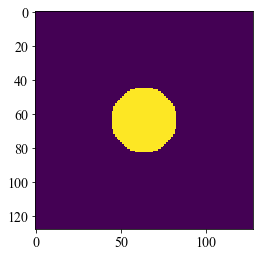

In [4]:
plt.imshow(pupil)

In [5]:
# =========================================================================
# =========================================================================

def mas2rad(x):
    ''' Convenient little function to convert milliarcsec to radians '''
    return x*np.pi/(180*3600*1000)

# =========================================================================
# =========================================================================

def rad2mas(x):
    ''' Convenient little function to convert radians to milliarcseconds '''
    return x/np.pi*(180*3600*1000)


In [6]:
fftshift = np.fft.fftshift
fft = np.fft.fft2

def propagate(pupil):
    scale = pupil
    return fftshift(fft(fftshift(pupil)))

In [7]:
psf = propagate(pupil)

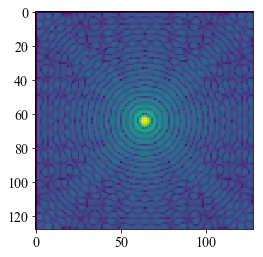

In [8]:
plt.imshow(np.abs(psf)**0.25)
# plt.xlim(500,524)
# plt.ylim(500,524)

In [9]:
uv = fftshift(fft((np.abs(psf)**2)))

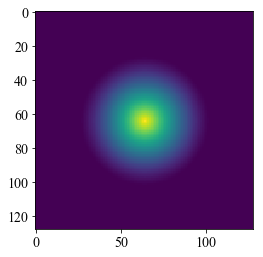

In [10]:
plt.imshow(np.abs(uv))

In [11]:
from autograd import grad, elementwise_grad, jacobian

In [12]:
def get_psf(screen):
    return propagate(pupil*np.exp(1.j*screen))
    
def get_uv(psf):
    return fftshift(fft(fftshift(np.abs(psf)**2)))

def get_phases(screen):
    return np.angle(get_uv(get_psf(screen)))

In [13]:
from scipy.signal import correlate2d, convolve2d

In [14]:
support = convolve2d(pupil,pupil,mode='same')>0

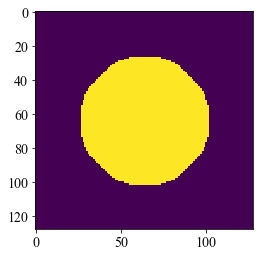

In [15]:
plt.imshow(support)

In [16]:
phasegrad = jacobian(get_phases)

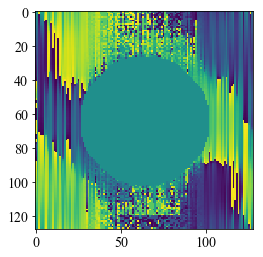

In [17]:
plt.imshow((get_phases(pupil)))


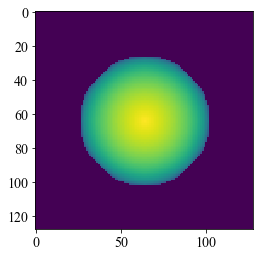

In [18]:
plt.imshow(np.abs(get_uv(psf))**0.2)

In [19]:
%%time 
thisgrad = phasegrad(np.zeros_like(pupil))

CPU times: user 35.1 s, sys: 1.78 s, total: 36.9 s
Wall time: 36.9 s


In [20]:
get_phases(np.zeros_like(pupil))

array([[ 0.        , -0.03563907, -2.97633245, ...,  2.31162827,
         3.05284211, -0.3611106 ],
       [ 0.04911063,  0.04349599,  2.98009348, ...,  2.13064692,
         2.90743327, -0.23452814],
       [ 0.0790944 ,  0.11184858,  2.72881318, ...,  2.05924696,
         2.80638216, -0.14203692],
       ...,
       [-0.12361345, -0.26423628, -2.38469299, ..., -2.8603063 ,
        -2.8776247 , -0.66605477],
       [-0.0790944 , -0.18395073, -2.49738059, ...,  3.09399191,
        -2.97522217, -0.55375132],
       [-0.04911063, -0.12153579, -2.67219938, ...,  2.65160138,
        -3.09005951, -0.46814683]])

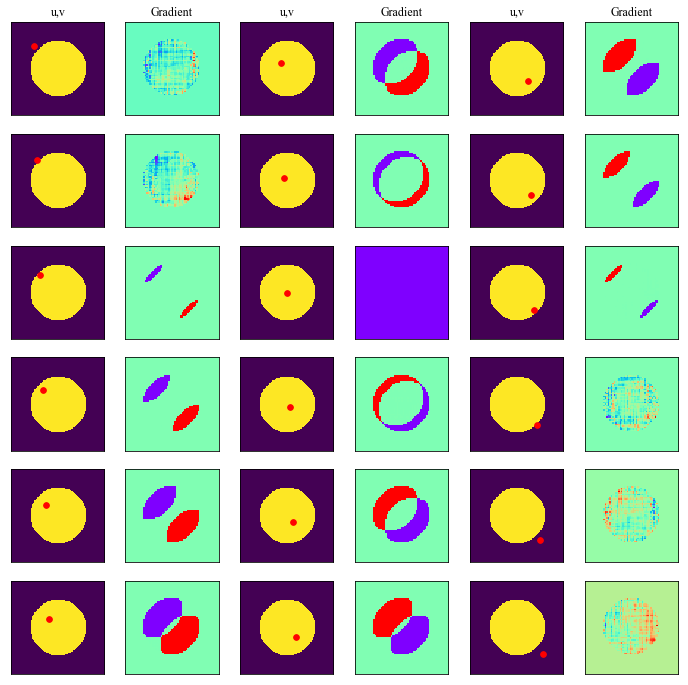

In [91]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('u,v')

        ax[i,j].imshow(support)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('../paper/jacobian.pdf',bbox_inches='tight')

In [22]:
transfer_martinache = thisgrad[support>0,:,:][:,pupil>0]

In [23]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache)

CPU times: user 15.2 s, sys: 475 ms, total: 15.7 s
Wall time: 4.12 s


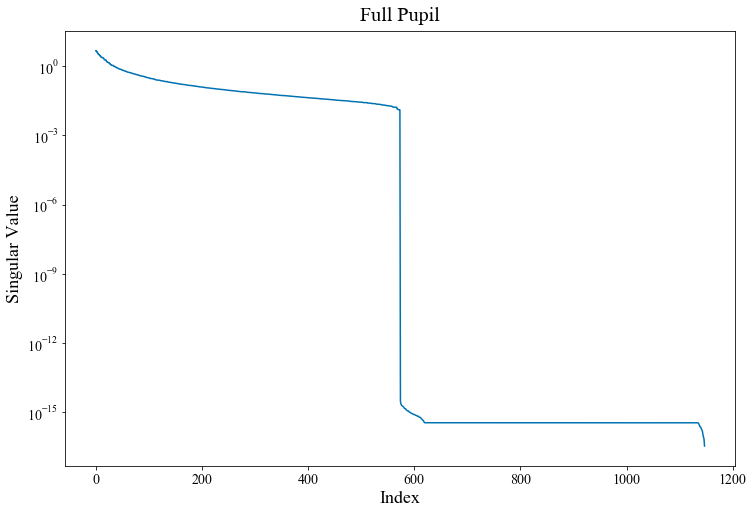

In [24]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('../paper/kerphi_singular.pdf',bbox_inches='tight')

### Now let's try a coronagraph!

In [25]:
x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])


In [26]:
x.min(),x.max()

(-64.0, 64.0)

In [27]:
xx, yy = np.meshgrid(x,x)
xx.min(),xx.max()

(-64.0, 64.0)

In [28]:
def make_stop(psf):
    x = np.linspace(-psf.shape[0]/2.,psf.shape[0]/2.,psf.shape[0])-0.5
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr < 8.
    stop = np.ones_like(rr)
    stop[mask] = 0
    return stop



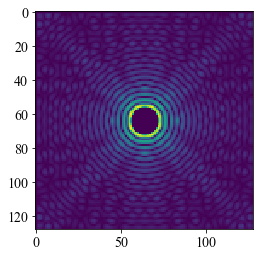

In [29]:
stop = make_stop(psf)
stopped = stop*psf
plt.imshow(np.abs(stopped))

In [30]:
lyot = make_pupil(3*units.m*0.85,npix=128,rtot=20*units.m,offset=1)

In [31]:
lyot_plane = propagate(stopped)

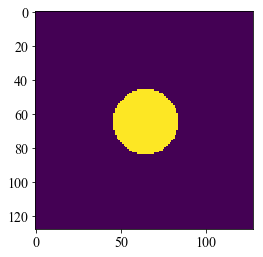

In [32]:
test = (propagate(psf))
plt.imshow(np.abs(test)**0.25)

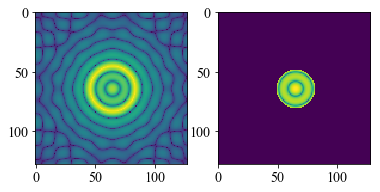

In [37]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(np.abs(lyot_plane)**0.2)
ax2.imshow(np.abs(lyot_plane*lyot)**0.2)

In [38]:
final = propagate(lyot_plane*lyot)

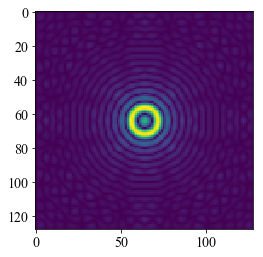

In [39]:
plt.imshow(np.abs(final))

In [40]:
def get_speckles(screen):
    return np.abs(propagate(lyot*propagate(stop*get_psf(screen))))

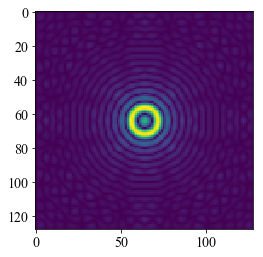

In [41]:
speckles = get_speckles(np.zeros_like(pupil))
plt.imshow(np.abs(speckles))

In [42]:
speckle_grad = jacobian(get_speckles)

In [43]:
%%time 
new_grad = speckle_grad(np.zeros_like(pupil))

CPU times: user 40.8 s, sys: 1.82 s, total: 42.7 s
Wall time: 42.8 s


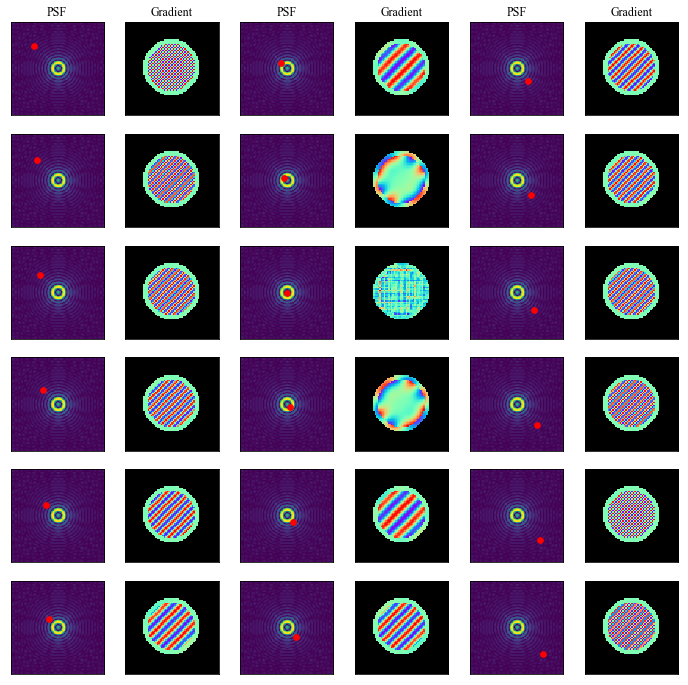

In [94]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 32


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
        phases = new_grad[indices,indices,:,:]
        phases[pupil==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)
        ax[i,1+j].set_xlim(32,128-32)
        ax[i,1+j].set_ylim(128-32,32)
        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('Gradient')
            ax[i,j].set_title('PSF')

        ax[i,j].imshow(speckles)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        indices += 4

plt.savefig('speckle_jacobian.png',bbox_inches='tight')
plt.savefig('../paper/speckle_jacobian.pdf',bbox_inches='tight')

### Let's make this into a phase transfer matrix

In [45]:
new_grad.shape

(128, 128, 128, 128)

In [46]:
test = np.reshape(new_grad,(128**2,128**2))

In [47]:
test.shape

(16384, 16384)

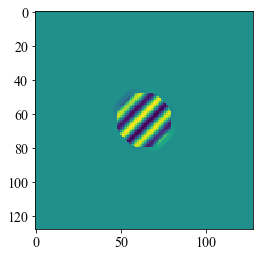

In [48]:
plt.imshow(np.reshape(test,(128,128,128,128))[55,55,:,:])

In [49]:
transfer = new_grad[:,:,pupil>0].reshape(128**2,np.sum(pupil>0))

In [50]:
transfer.shape

(16384, 1148)

In [51]:
%%time
u, s, v = np.linalg.svd(transfer)

CPU times: user 3min 36s, sys: 3.9 s, total: 3min 40s
Wall time: 1min 1s


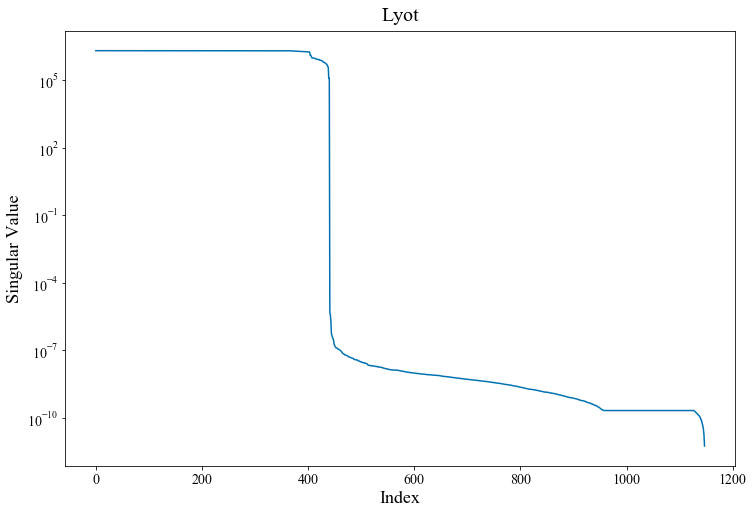

In [52]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s)
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Singular Value Spectrum of a Lyot Coronagraph',fontsize=24,y=1.01)
plt.title('Lyot', y=1.01,fontsize=20)
plt.savefig('coronagraph_singular.png',bbox_inches='tight')
plt.savefig('../paper/coronagraph_singular.pdf',bbox_inches='tight')

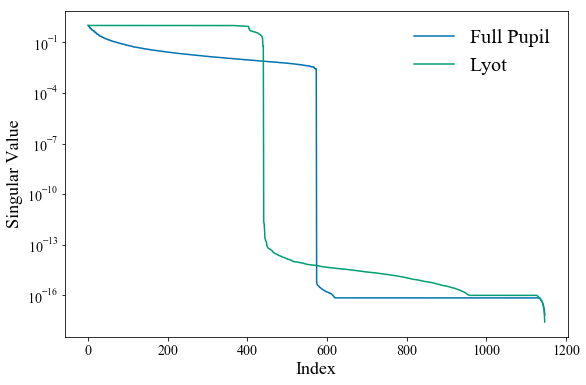

In [60]:
fig = plt.figure(figsize=(9.0,6.0))
plt.plot(s1/s1[0],label='Full Pupil')
plt.plot(s/s[0],label='Lyot')
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')

# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
# plt.title('Full Pupil',y=1.01,fontsize=20)
plt.legend(fontsize=20,frameon=False)
plt.savefig('all_singular.png',bbox_inches='tight')
plt.savefig('../paper/all_singular.pdf',bbox_inches='tight')

In [54]:
s[1000]/s[0]

9.992007221626368e-17

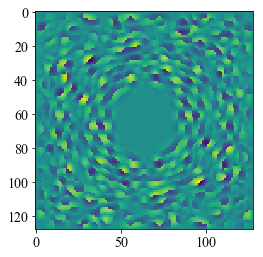

In [55]:
plt.imshow(u[:,0].reshape(128,128))

(32, 96)

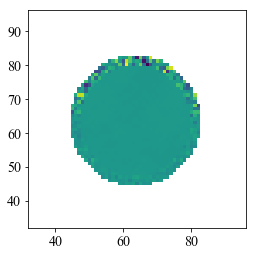

In [56]:
mask = pupil>0
wavefront = np.ones_like(pupil)
wavefront[mask] *= v[1100,:]
wavefront[~mask] = np.nan

plt.imshow(wavefront)

plt.xlim(32,128-32)
plt.ylim(32,128-32)

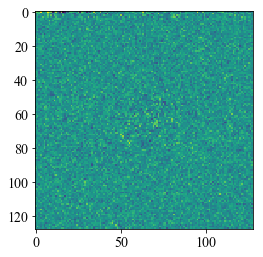

In [57]:
plt.imshow(u[:,1136].reshape(128,128))

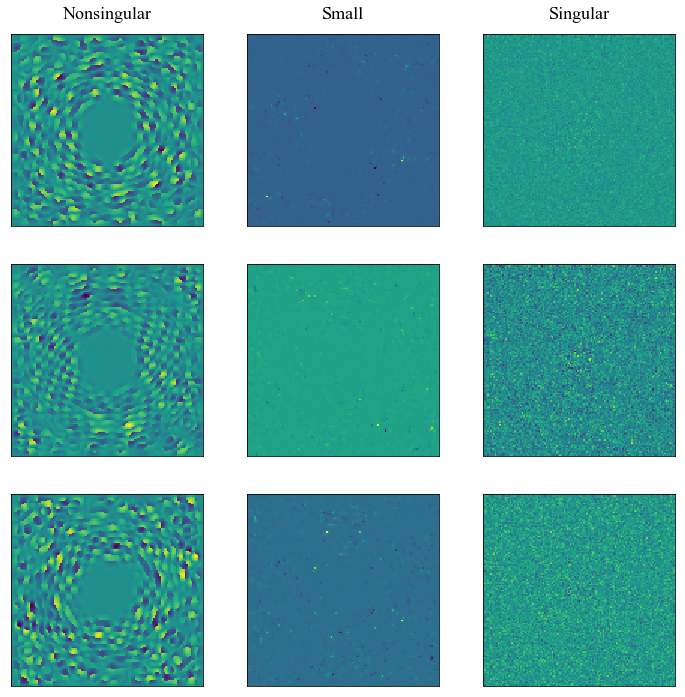

In [58]:
nsets = 3

fig, axes = plt.subplots(nsets,3,figsize=(12.0,12/3.*nsets),sharex=True, sharey=True)

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)

for j in range(nsets):
    axes[j,0].imshow(u[:,j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,1].imshow(u[:,600+j*10].reshape(128,128))
    
for j in range(nsets):
    axes[j,2].imshow(u[:,1000+j*10].reshape(128,128))
    
plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')

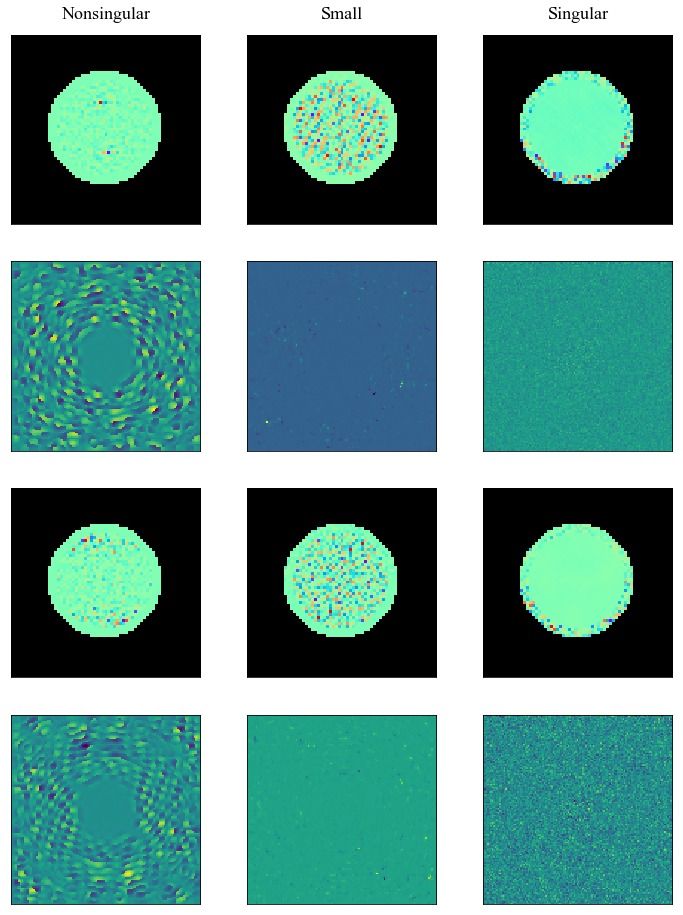

In [78]:
nsets = 2

fig, axes = plt.subplots(nsets*2,3,figsize=(12.0,12/3.*(nsets*2)))

for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(aspect='equal')

axes[0,0].set_title('Nonsingular',fontsize=18,y=1.05)
axes[0,1].set_title('Small',fontsize=18,y=1.05)
axes[0,2].set_title('Singular',fontsize=18,y=1.05)


for j in range(nsets):
    axes[j*2+1,0].imshow(u[:,j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,0].imshow(wavefront,cmap=phasemap)
    current_cmap = mpl.cm.get_cmap()
    current_cmap.set_bad(color='k')

    axes[j*2,0].set_xlim(32,128-32)
    axes[j*2,0].set_ylim(128-32,32)

    
for j in range(nsets):
    axes[j*2+1,1].imshow(u[:,600+j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[600+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,1].imshow(wavefront,cmap=phasemap)
    axes[j*2,1].set_xlim(32,128-32)
    axes[j*2,1].set_ylim(128-32,32)

for j in range(nsets):
    axes[j*2+1,2].imshow(u[:,1000+j*10].reshape(128,128))
    wavefront = np.ones_like(pupil)
    wavefront[mask] *= v[1000+j*10,:]
    wavefront[~mask] = np.nan
    axes[j*2,2].imshow(wavefront,cmap=phasemap)
    axes[j*2,2].set_xlim(32,128-32)
    axes[j*2,2].set_ylim(128-32,32)

plt.savefig('../paper/coronagraph_kernel.pdf',bbox_inches='tight')